In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torch.backends.cudnn as cudnn
import torchvision
import torchvision.transforms as transforms
import os
import argparse
from finalmodel import ResNet18, ResNet, BasicBlock
from torchsummary import summary
import random
import numpy as np

In [2]:
SEED = 7772
torch.manual_seed(SEED)
random.seed(SEED)
np.random.seed(SEED)

In [3]:
from functools import reduce

In [4]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [5]:
def build_model(sizes):
  return ResNet(BasicBlock, sizes)

In [6]:
N = 1
B = [2] * N
C = [32, 64, 128, 256, 512] 
F_i = 3

P = 1
PARAM_COUNT = 5_000_000 #5 million

from collections import defaultdict
good_models = defaultdict(list)
from itertools import permutations, product
for n in range(1, N+1):
    perms = product([0,1,2,4,8], repeat=4)
    for p in perms:
      B = list(p)
      model = build_model(B).to(device)
      total_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
      if total_params <= PARAM_COUNT:
          print(B)
          print("params: ", total_params)
          print()
          good_models[total_params].append(model)

[0, 0, 0, 0]
params:  4903242

[0, 0, 0, 1]
params:  4903242

[0, 0, 1, 0]
params:  4903242

[0, 0, 1, 1]
params:  4903242

[0, 1, 0, 0]
params:  4903242

[0, 1, 0, 1]
params:  4903242

[0, 1, 1, 0]
params:  4903242

[0, 1, 1, 1]
params:  4903242

[1, 0, 0, 0]
params:  4903242

[1, 0, 0, 1]
params:  4903242

[1, 0, 1, 0]
params:  4903242

[1, 0, 1, 1]
params:  4903242

[1, 1, 0, 0]
params:  4903242

[1, 1, 0, 1]
params:  4903242

[1, 1, 1, 0]
params:  4903242

[1, 1, 1, 1]
params:  4903242

[2, 0, 0, 0]
params:  4977226

[2, 0, 0, 1]
params:  4977226

[2, 0, 1, 0]
params:  4977226

[2, 0, 1, 1]
params:  4977226

[2, 1, 0, 0]
params:  4977226

[2, 1, 0, 1]
params:  4977226

[2, 1, 1, 0]
params:  4977226

[2, 1, 1, 1]
params:  4977226



In [7]:
print("Total Good Models: ", len(good_models.keys()))

Total Good Models:  2


In [8]:
transform_train = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(20),
    transforms.RandomCrop(size=32, padding=[0, 2, 3, 4]),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

trainset = torchvision.datasets.CIFAR10(
    root='./data', train=True, download=True, transform=transform_train)
trainloader = torch.utils.data.DataLoader(
    trainset, batch_size=64, shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(
    root='./data', train=False, download=True, transform=transform_test)
testloader = torch.utils.data.DataLoader(
    testset, batch_size=50, shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat', 'deer',
           'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


In [9]:
image, label = trainset[0]
print(image.shape, label)

torch.Size([3, 32, 32]) 6


In [10]:
net = ResNet18()
net = net.to(device)
if device == 'cuda':
    net = torch.nn.DataParallel(net)
    cudnn.benchmark = True
    
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=.01,
                      momentum=0.9, weight_decay=5e-4)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=200)

In [11]:
summary(net,image.shape)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 32, 32]           1,728
       BatchNorm2d-2           [-1, 64, 32, 32]             128
            Conv2d-3           [-1, 64, 32, 32]          36,864
       BatchNorm2d-4           [-1, 64, 32, 32]             128
            Conv2d-5           [-1, 64, 32, 32]          36,864
       BatchNorm2d-6           [-1, 64, 32, 32]             128
        BasicBlock-7           [-1, 64, 32, 32]               0
            Conv2d-8          [-1, 128, 16, 16]          73,728
       BatchNorm2d-9          [-1, 128, 16, 16]             256
           Conv2d-10          [-1, 128, 16, 16]         147,456
      BatchNorm2d-11          [-1, 128, 16, 16]             256
           Conv2d-12          [-1, 128, 16, 16]           8,192
      BatchNorm2d-13          [-1, 128, 16, 16]             256
       BasicBlock-14          [-1, 128,

In [12]:
train_loss_history = []
test_loss_history = []
accuracy_history = []
for epoch in range(0,150):

    print('\nEpoch: %d' % epoch)
    net.train()
    train_loss = 0
    correct = 0
    total = 0
    for batch_idx, (inputs, targets) in enumerate(trainloader):
        inputs, targets = inputs.to(device), targets.to(device)
        optimizer.zero_grad()
        outputs = net(inputs)
        loss = criterion(outputs,targets)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        _, predicted = outputs.max(1)
        total += targets.size(0)
        correct += predicted.eq(targets).sum().item()
    acc1=100*correct/total
   
    global best_acc
    net.eval()
    test_loss = 0
    correct1 = 0
    total1 = 0
    acc=0
    with torch.no_grad():
        for batch_idx, (inputs, targets) in enumerate(testloader):
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = net(inputs)
            loss = criterion(outputs, targets)
            test_loss += loss.item()
            _, predicted = outputs.max(1)
            total1 += targets.size(0)
            correct1 += predicted.eq(targets).sum().item()
    acc = 100.*correct1/total1
    train_loss_history.append(train_loss)
    test_loss_history.append(test_loss)
    accuracy_history.append(acc)
    print('Epoch %s, Train loss %s, Test loss %s, Accuracy %s'%(epoch, train_loss, test_loss, acc))


Epoch: 0
Epoch 0, Train loss 1185.9647044539452, Test loss 261.0464889407158, Accuracy 53.98

Epoch: 1
Epoch 1, Train loss 895.8092020750046, Test loss 194.70115292072296, Accuracy 65.36

Epoch: 2
Epoch 2, Train loss 766.838760137558, Test loss 169.3367090523243, Accuracy 70.52

Epoch: 3
Epoch 3, Train loss 673.1606594026089, Test loss 163.67675477266312, Accuracy 71.61

Epoch: 4
Epoch 4, Train loss 609.4876143634319, Test loss 158.03608870506287, Accuracy 73.09

Epoch: 5
Epoch 5, Train loss 563.0885302722454, Test loss 121.65910959243774, Accuracy 79.39

Epoch: 6
Epoch 6, Train loss 530.399913996458, Test loss 115.54643373191357, Accuracy 80.15

Epoch: 7
Epoch 7, Train loss 491.0487681925297, Test loss 110.61277632415295, Accuracy 80.36

Epoch: 8
Epoch 8, Train loss 464.2114199101925, Test loss 125.1091413795948, Accuracy 78.97

Epoch: 9
Epoch 9, Train loss 444.3897643685341, Test loss 122.83037221431732, Accuracy 78.85

Epoch: 10
Epoch 10, Train loss 425.78731332719326, Test loss 11

In [18]:
from matplotlib import pyplot as plt

SGD optimizer
Accuracy History


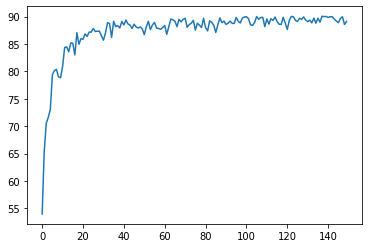

In [19]:
print("SGD optimizer")
print("Accuracy History")
plt.plot([i for i in range(150)], [i for i in accuracy_history])

SGD optimizer
Test Loss History


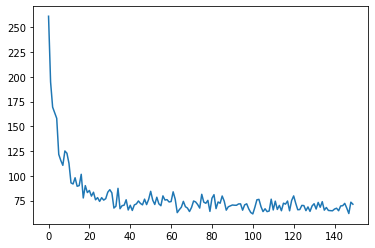

In [20]:
print("SGD optimizer")
print("Test Loss History")
plt.plot([i for i in range(150)], [i for i in test_loss_history])

In [21]:
model_path = './project1_model.pt'
torch.save(net.state_dict(), model_path)